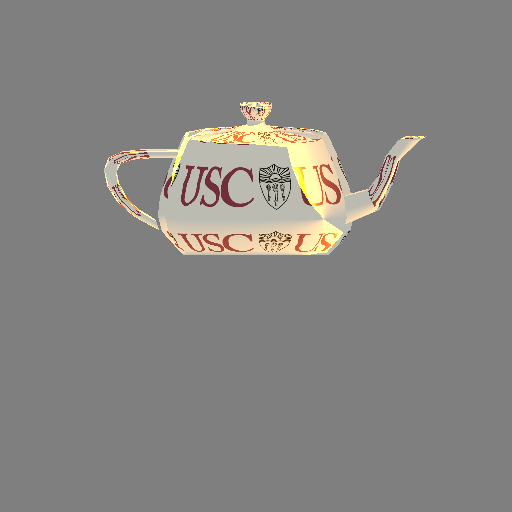

In [31]:
import json
import math
import numpy as np
from PIL import Image


def find_len(p):
  return math.sqrt(p[0]*p[0] + p[1]*p[1] + p[2]*p[2])

def unitize(p):
  l = find_len(p)
  return [p[0]/l, p[1]/l, p[2]/l]

def cross(pA, pB):
  a1, a2, a3 = pA[0], pA[1], pA[2];
  b1, b2, b3 = pB[0], pB[1], pB[2];
  param1 = a2 * b3 - a3 * b2
  param2 = a3 * b1 - a1 * b3
  param3 = a1 * b2 - a2 * b1
  return [param1, param2, param3]

def createCamMatrix(camR, to):
  camU = [1, 0, 0]
  camV = [0, 1, 0]
  camN = [0, 0, 1]
  camMatrix = [[0] * 4 for i in range(4)]
  camMatrix[0] = [camU[0], camU[1], camU[2], -(camR[0]*camU[0]+camR[1]*camU[1]+camR[2]*camU[2])]
  camMatrix[1] = [camV[0], camV[1], camV[2], -(camR[0]*camV[0]+camR[1]*camV[1]+camR[2]*camV[2])]
  camMatrix[2] = [camN[0], camN[1], camN[2], -(camR[0]*camN[0]+camR[1]*camN[1]+camR[2]*camN[2])]
  camMatrix[3] = [0, 0, 0, 1]
  return camMatrix


def multiplyMatrixAndPoint(matrix, point):
  c0r0, c1r0, c2r0, c3r0 = matrix[0][0], matrix[0][1], matrix[0][2], matrix[0][3]
  c0r1, c1r1, c2r1, c3r1 = matrix[1][0], matrix[1][1], matrix[1][2], matrix[1][3]
  c0r2, c1r2, c2r2, c3r2 = matrix[2][0], matrix[2][1], matrix[2][2], matrix[2][3]
  c0r3, c1r3, c2r3, c3r3 = matrix[3][0], matrix[3][1], matrix[3][2], matrix[3][3]

  resultX = (point[0] * c0r0) + (point[1] * c1r0) + (point[2] * c2r0) + (point[3] * c3r0)
  resultY = (point[0] * c0r1) + (point[1] * c1r1) + (point[2] * c2r1) + (point[3] * c3r1)
  resultZ = (point[0] * c0r2) + (point[1] * c1r2) + (point[2] * c2r2) + (point[3] * c3r2)
  resultW = (point[0] * c0r3) + (point[1] * c1r3) + (point[2] * c2r3) + (point[3] * c3r3)

  return [resultX, resultY, resultZ, resultW]

def WSToNDC(camMatrix,NDCMat,vert):
  pt = [vert[0],vert[1],vert[2], 1]
  camPt = multiplyMatrixAndPoint(camMatrix,pt)
  proj_plane = 3
  doItForReal=1
  if doItForReal == 1:
    NDCPt = multiplyMatrixAndPoint(NDCMat,camPt)
    NDCx = NDCPt[0]/NDCPt[3]
    NDCy = NDCPt[1]/NDCPt[3]
    NDCz = NDCPt[2]/NDCPt[3]
  return [NDCx,NDCy]
  
def numpyMultiplication(mat, val):
  return np.multiply(mat, val)

#Texture Image
im11 = Image.open("logo.jpeg")


def texture_lookup(u, v, texture_map):
   xLocation = u * 449 #texmap's xres-1
   yLocation = v * 217 #texmap's xres-1
  #  print(xLocation, yLocation)
   p00 = [math.floor(xLocation), math.floor(yLocation)]     # bottom-left
   p11 = [1+math.floor(xLocation), 1+math.floor(yLocation)] #top-right (diagonal)
   p10 = [1+math.floor(xLocation), math.floor(yLocation)]   # to the right of p00
   p01 = [math.floor(xLocation), 1+math.floor(yLocation)]   # to the top of p00
   f = xLocation - math.floor(xLocation)
   g = yLocation - math.floor(yLocation)
   p0010RGB = np.dot(f , (texture_map.getpixel((p10[0], p10[1])))) + np.dot((1 - f) , texture_map.getpixel((p00[0], p00[1])))
   p0111RGB = np.dot(f , (texture_map.getpixel((p11[0], p11[1])))) + np.dot((1 - f) , texture_map.getpixel((p01[0], p01[1])))
  #  print('p0010RGB>> ',p0010RGB,p0111RGB)
   pOutputRGB = g * (p0111RGB - p0010RGB) + p0010RGB
   return pOutputRGB

def normalizeVal(normal):
  denominator = normal[0] * 2 + normal[1]*2 + normal[2] * 2
  res = [normal[0] / denominator, normal[1] / denominator, normal[2] / denominator]
  return res

def shading(materials, normal, lights_data):
  cs = materials['Cs']
  ka = materials['Ka']
  kd = materials['Kd']
  ks = materials['Ks']
  le = lights_data[1]['intensity']
  L = lights_data[1]['from']
  la = lights_data[0]['intensity']
  n = materials['n']
  normal = normalizeVal(normal)
  R = normalizeVal(np.subtract(numpyMultiplication(normal, 2 * np.dot(normal, L)), L))
  ambient_light = numpyMultiplication(numpyMultiplication(lights_data[0]['color'], la), ka)
  diffused_light = numpyMultiplication(kd * max(np.dot(L, normal), 0) * le, lights_data[1]['color'])
  specular_light = numpyMultiplication(ks * math.pow(np.dot(R, [0, 0, 0]), n) * le, lights_data[1]['color'])
  ambi_diff = np.add(ambient_light, diffused_light)
  color = numpyMultiplication(ambi_diff, cs)
  color = np.add(color, specular_light)
  return [int(color[0] * 255) , int(color[1] * 255), int(color[2] * 255)]

#Alias Values
dxList = [-0.52/511, 0.41/511, 0.27/511, -0.17/511, 0.58/511, -0.31/511]
dyList = [0.38/511, 0.56/511, 0.08/511, -0.29/511, -0.55/511, -0.71/511]
weightList = [0.128, 0.119, 0.294, 0.249, 0.104, 0.106]

#Shading values
Cs = [1, 0 , 0]
Ka= 0.5
Kd = 0.75
Ks = 0.9
n = 2.0



with open('./Teapot5.json') as json_file:
    data = json.load(json_file)

fro = [0, 0, 20]
to = [0, 0, 0]


dist = 10.0
n, f, r, l, t, b = 40, 10, dist, -dist, -dist, dist
NDCMat = [[2*n/(r-l), 0, (r+l)/(r-l), 0], 
          [0, 2*n/(t-b), (t+b)/(t-b), 0], 
          [0, 0, -(f+n)/(f-n), -2*f*n/(f-n)], 
          [0, 0, -1, 0]]
NDCPt = [[], [], []]
w, h = 512, 512
img = Image.new('RGB',(w, h), (127,127,127))
z_buffer = [[math.inf] * 512 for i in range(512)]
data1 = data.get('data')
camMatrix = createCamMatrix(fro, to)


i = 0

lights =[
      {
        "id":"L1",
        "type":"ambient",
        "color":[
          1,
          1,
          1
        ],
        "intensity":0.2
      },
      {
        "id":"L2",
        "type":"directional",
        "color":[
          1,
          0.5,
          1
        ],
        "intensity":0.1,
        "from":[
          15,
          5,
          0
        ],
        "to":[
          0,
          0,
          0
        ]
      }
    ]
materials = {
          "Cs":[
            0.2,
            0.2,
            0
          ],
          "Ka":0.9,
          "Kd":0.75,
          "Ks":0.9,
          "n":2.0
        }

lights_data = [{
    "id": "L1",
    "type": "ambient",
    "color": [
      1,
      1,
      1
    ],
    "intensity": 0.2
  },
  {
    "id": "L2",
    "type": "directional",
    "color": [
      1,
      0.5,
      1
    ],
    "intensity": 0.6,
    "from": [
      0,
      10,
      0
    ],
    "to": [
      0,
      0,
      0
    ]
  }
]

for dat in data1:
  i += 1
  x0 = dat['v0']['v'][0]
  x1 = dat['v1']['v'][0]
  x2 = dat['v2']['v'][0]
  y0 = dat['v0']['v'][1]
  y1 = dat['v1']['v'][1]
  y2 = dat['v2']['v'][1]
  z0 = dat['v0']['v'][2]
  z1 = dat['v1']['v'][2]
  z2 = dat['v2']['v'][2]

  nx0 = dat['v0']['n'][0]
  ny0 = dat['v0']['n'][1]
  nz0 = dat['v0']['n'][2]
  nx1 = dat['v1']['n'][0]
  ny1 = dat['v1']['n'][1]
  nz1 = dat['v1']['n'][2]
  nx2 = dat['v2']['n'][0]
  ny2 = dat['v2']['n'][1]
  nz2 = dat['v2']['n'][2]

  nvert0 = [nx0, ny0, nz0, 1]
  nvert1 = [nx1, ny1, nz1, 1]
  nvert2 = [nx2, ny2, nz2, 1]

  tu1, tv1 = dat['v0']['t'][0], dat['v0']['t'][1]
  tu2, tv2 = dat['v1']['t'][0], dat['v1']['t'][1]
  tu3, tv3 = dat['v2']['t'][0], dat['v2']['t'][1]

  vertex_all = [[x0, y0, z0], [x1, y1, z1], [x2, y2, z2]]
  NDCPt[0] = WSToNDC(camMatrix, NDCMat, vertex_all[0])
  NDCPt[1] = WSToNDC(camMatrix, NDCMat, vertex_all[1])
  NDCPt[2] = WSToNDC(camMatrix, NDCMat, vertex_all[2])

  scale = 511/2
  x0 = (NDCPt[0][0] + 1) * scale
  x1 = (NDCPt[1][0] + 1) * scale
  x2 = (NDCPt[2][0] + 1) * scale
  y0 = (NDCPt[0][1] + 1) * scale
  y1 = (NDCPt[1][1] + 1) * scale
  y2 = (NDCPt[2][1] + 1) * scale
  
  xmin = math.floor(min(x0, x1, x2))
  xmax = math.ceil(max(x0, x1, x2))
  ymin = math.floor(min(y0, y1, y2))
  ymax = math.ceil(max(y0, y1, y2))
  nx = dat['v0']['n'][0]
  ny = dat['v0']['n'][1]
  nz = dat['v0']['n'][2]
  dotp = float(0.707 * nx) + float(0.5 * ny) + float(0.5 * nz)

  if dotp < 0.0:
    dotp = -dotp
  elif dotp > 1.0:
    dotp = 1.0
  
  rgb = [float(0.95 * dotp), float(0.65 * dotp), float(0.88 * dotp)]
  col = (int(rgb[0] * 255) ,int(rgb[1] * 255), int(rgb[2] * 255))

  
  for y in range(ymin,ymax):
    for x in range(xmin, xmax):
      
      f01 = (y0-y1)*x + (x1-x0)*y + x0*y1 - x1*y0
      f12 = (y1-y2)*x + (x2-x1)*y + x1*y2 - x2*y1
      f20 = (y2-y0)*x + (x0-x2)*y + x2*y0 - x0*y2
      f01a = (y0-y1)*x2 + (x1-x0)*y2 + x0*y1 - x1*y0
      f12a = (y1-y2)*x0 + (x2-x1)*y0 + x1*y2 - x2*y1
      f20a = (y2-y0)*x1 + (x0-x2)*y1 + x2*y0 - x0*y2
      alpha = f12/f12a
      beta = f20/f20a
      gamma = f01/f01a
      n11 = numpyMultiplication(nvert0, alpha)
      n22 = numpyMultiplication(nvert1, beta)
      n33 = numpyMultiplication(nvert2, gamma)
      normal_final_all = np.add(np.add(n11, n22), n33)
      # normal_final_all = [numpyMultiplication(normal_translated_all[0], alpha),numpyMultiplication(normal_translated_all[1], beta),numpyMultiplication(normal_translated_all[2], gamma)]

      


      
      z_at_pixel = alpha * z0 + beta * z1 + gamma * z2
      if(alpha >= 0 and beta >=0 and gamma >= 0):
        if(x >= 0 and y >= 0 and x < 512 and y < 512):
          if z_at_pixel < z_buffer[x][y]:
            if z0 !=0 and z1!=0 and z2!=0:
              u_pix = alpha*tu1/z0 + beta*tu2/z1 + gamma*tu3/z2
              v_pix = alpha*tv1/z0 + beta*tv2/z1 + gamma*tv3/z2
              z_pix = 1 / (alpha/z0 + beta/z1 + gamma/z2)
              u_pix *= z_pix
              v_pix *= z_pix
              
              texture_vals = texture_lookup(u_pix,v_pix,im11)
              rgb1 = texture_vals * 0.7
              triColor = shading(materials,normal_final_all,lights_data)
              rgb = texture_vals * 0.7 + triColor
              color1 = (int(rgb[0]), int(rgb[1]), int(rgb[2]))
              
              
              # for i in range(6):
              #   x += (x + dxList[i]) * weightList[i]
              #   y += (y + dyList[i]) * weightList[i]
              # x = x/6
              # y = y/6

              xa = ((x + dxList[0]) * weightList[0]) +((x + dxList[1]) * weightList[1]) +((x + dxList[2]) * weightList[2]) + ((x + dxList[3]) * weightList[3]) +((x + dxList[4]) * weightList[4])+((x + dxList[5]) * weightList[5])
              ya = ((y + dyList[0]) * weightList[0]) +((y + dyList[1]) * weightList[1]) +((y + dyList[2]) * weightList[2]) + ((y + dyList[3]) * weightList[3]) +((y + dyList[4]) * weightList[4])+((y + dyList[5]) * weightList[5])

              # x1 = x + (dxList[0] * weightList[0] + dxList[1] * weightList[1] + dxList[2] * weightList[2] + dxList[3] * weightList[3] + dxList[4] * weightList[4]  + dxList[5] * weightList[5] )
              # x1 = x + (dyList[0] * weightList[0] + dyList[1] * weightList[1] + dyList[2] * weightList[2] + dyList[3] * weightList[3] + dyList[4] * weightList[4]  + dyList[5] * weightList[5] )
              # x = (x + dxList[0]) * weightList[1]
              # y = (y + dyList[0]) * weightList[1]
              # x = (x + dxList[1]) * weightList[1]
              # y = (y + dyList[1]) * weightList[1]
              # x = (x + dxList[2]) * weightList[2]
              # y = (y + dyList[2])  * weightList[2]
              # x = (x + dxList[3]) * weightList[3]
              # y = (y + dyList[3])* weightList[3]
              # x = (x + dxList[4]) * weightList[4]
              # y = (y + dyList[4])  * weightList[4]
              # x = (x + dxList[5]) * weightList[5]
              # y = (y + dyList[5])* weightList[5]
              if(xa >= 0 and ya >= 0 and xa< 512 and ya < 512):  
                img.putpixel((int(xa),int(ya)),color1)
                z_buffer[int(x)][int(y)] = z_at_pixel
display(img)